# Simple Trading Strategies

Estas estrategias seran probadas directamente en Binance Futures para determinar buenas o malas alternativas para invertir en el momento

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from trading import Asset
import pandas as pd
import numpy as np
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from trading.assets.binance import Binance
from trading.testers.rules_testing import RuleTesting, rule_validation
from sklearn.model_selection import ParameterGrid
from scipy.ndimage import gaussian_filter1d

In [4]:
END = datetime.today()
START = END - relativedelta( minutes=5*12*48 ) # 48 horas de info
FREQ = "5min"

In [5]:
bi = Binance(symbol="")
futures_exchange_info = bi.client.futures_exchange_info()  # request info on all futures symbols
trading_pairs = [info['symbol'] for info in futures_exchange_info['symbols']]
bad = ["USDCUSDT"]
ASSETS = [ ( t[:-4], t[-4:] ) for t in trading_pairs if (t[-4:] == "USDT" and t not in bad)][:15]
ASSETS

[('ACH', 'USDT'),
 ('CHZ', 'USDT'),
 ('CFX', 'USDT'),
 ('FET', 'USDT'),
 ('BAKE', 'USDT'),
 ('BLZ', 'USDT'),
 ('APE', 'USDT'),
 ('ANKR', 'USDT'),
 ('SXP', 'USDT'),
 ('FLOW', 'USDT'),
 ('DOT', 'USDT'),
 ('RDNT', 'USDT'),
 ('FIL', 'USDT'),
 ('1000SHIB', 'USDT'),
 ('LIT', 'USDT')]

In [6]:
def get_asset( symbol ):

    end = datetime.now()

    return Asset(
        symbol,
        broker = "binance",
        fiat = "USDT",

        start = end - relativedelta(minutes=5*12*24*7),
        end =  end,

        frequency = "3min",

        source = "ext_api"
    )

In [7]:
def pipeline(func):

    values = []

    for symbol, _ in ASSETS:

        asset = get_asset( symbol )

        if asset.df is None or len(asset.df) == 0:
            print("No info from source")
            continue

        return_value = func( asset )

        values.append([ symbol, return_value ])
    
    values = pd.DataFrame(values)
    values.columns = [ "symbol", "value" ]
    values.sort_values(by = "value", ascending=False, inplace = True)

    return values
    

In [8]:
def sell_column(asset, target ):
    asset.df["sell"] = False
    true_values = asset.df[ asset.df["buy"] == True ].index.tolist()
    close = asset.df["close"]

    for i in true_values:
        close_price = close[i]
        close_aux = close[ i: ]
        close_aux = ( close_aux / close_price ) - 1
        pct_index = close_aux[ close_aux > target ]

        if len(pct_index) == 0:
            # Este mensaje no importa por el momento, solo nos indica que como no hay mejor, yo no
            # nos moveremos a los siguientes puesto
            # que al no cerrarse esta orden, no podemos abrir ni cerrar las demas.
            # raise Exception( "Testing did not prove a better return." )
            break
        
        pct_index = pct_index.index[0]

        try:
            asset.df.loc[ pct_index, "sell" ] = True
        except Exception as e:
            raise Exception( f"{e}. Got {type(pct_index)} from {pct_index}." )
    
    return asset

In [9]:
 def pipeline2(func, *args, **kwargs):

    values = []

    for symbol, _ in ASSETS:

        asset = get_asset( symbol )

        if asset.df is None or len(asset.df) == 0:
            print("No info from source")
            continue

        return_df = func( asset, *args, **kwargs )

        if return_df is None or len(return_df) == 0:
           continue

        acc = return_df["acc"].iloc[-1]
        net = return_df["returns"].mean()
        max_drawdown = return_df["returns"].min()
        spread = return_df["returns"].max() - max_drawdown
        sharpe = net / return_df["returns"].std()
        transactions = len(return_df)
        mean_open_time = (return_df["date_sold"] - return_df["date_bought"]).mean()
        max_open_time = (return_df["date_sold"] - return_df["date_bought"]).max()

        values.append([ symbol, acc, net, max_drawdown, spread, sharpe, transactions , mean_open_time, max_open_time])
    
    values = pd.DataFrame(values)
    values.columns = [ "symbol", "acc", "net",  "max_drawdown", "spread", "sharpe" , "transactions", "mean_open_time", "max_open_time"]
    values.sort_values(by = "acc", ascending=False, inplace = True)

    return values
    

## Simple EMA

In [20]:
def simple_ema(asset):
    asset.df["ema"] = asset.ema(180)

    d = asset.df.iloc[-1].to_dict()

    if d["ema"] <= d["close"]:
        return ( d["close"]/d["ema"] ) - 1

    return False

In [24]:
simple_ema_results = pipeline( simple_ema )

In [25]:
simple_ema_results

,symbol,value
16,GALA,0.018998
6,TOMO,0.018293
15,BNX,0.01652
4,ALGO,0.015784
3,ADA,0.015114
8,MANA,0.014924
2,THETA,0.013431
13,ID,0.013372
10,REEF,0.012045
1,LRC,0.01178


## RSI std and RSI slope

In [21]:
def rsistd_rsislope(asset):
    asset.df["rss"] = asset.rsi_smoth_slope(30, 15, 2)
    asset.df["rsistd"] = asset.rsi_smoth( 30, 15 ).rolling(10).std().pct_change()

    d = asset.df.iloc[-1].to_dict()

    if d["rsistd"] > 0 and d["rss"] > 0:
        return True
    
    return False
    

In [22]:
rsistd_rsislope_results = pipeline( rsistd_rsislope )

In [23]:
rsistd_rsislope_results

,symbol,value
6,TOMO,True
9,HOOK,True
0,OXT,False
1,LRC,False
2,THETA,False
3,ADA,False
4,ALGO,False
5,LQTY,False
7,DENT,False
8,MANA,False


## RSI slope, RSI std, EMA std

In [11]:
def rsislope_rsistd_ema_std(asset):

    asset.df["f1"] = asset.rsi_smoth( 15, 10 )
    asset.df["f2"] = asset.df["f1"].rolling(10).std() > 1.35
    asset.df["f3"] = asset.ema(15).rolling(10).std() > 0.001
    asset.df["f4"] = asset.df["f1"].pct_change() > 0

    d = asset.df.iloc[-1].to_dict()

    return (d["f4"] and d["f3"] and d["f2"])


In [15]:
def rsislope_rsistd_ema_std_2(asset):

    asset.df["f1"] = asset.rsi_smoth( 15, 10 )
    asset.df["f4"] = asset.df["f1"].pct_change() > 0

    asset.df["f2"] = asset.df["f1"].rolling(10).std().between(1.35, 3.9, inclusive = "neither")
    asset.df["f3"] = asset.ema(15).rolling(10).std() < 0.0009
    asset.df["f5"] = asset.cci( 20 ) < 150


    asset.df["buy"] = ( asset.df["f2"] & asset.df["f3"] & asset.df["f4"] & asset.df["f5"])

    
    asset = sell_column( asset, 0.0012 )

    return rule_validation(asset)

In [44]:
rre_result = pipeline( rsislope_rsistd_ema_std )

In [45]:
rre_result

,symbol,value
0,NMR,True
1,QTUM,True
2,DOT,True
10,COMP,True
11,OP,True
12,ENS,True
13,AVAX,True
3,DOGE,False
4,SOL,False
5,ARB,False


In [16]:
rre_result_df  = pipeline2( rsislope_rsistd_ema_std_2 )

C:\Users\ramon\AppData\Local\Temp\ipykernel_6548\4149549827.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


In [17]:
rre_result_df[["acc", "net", "max_drawdown", "spread", "sharpe", "transactions"]].mean()

acc              1.016583
net              0.000491
max_drawdown    -0.012917
spread           0.018167
sharpe                inf
transactions    50.833333
dtype: float64

0.0015 , period 1

acc             1.020900
net             0.001714
max_drawdown   -0.003100
spread          0.007700
sharpe          1.502867

0.0012

acc              1.018700
net              0.001457
max_drawdown    -0.002900
spread           0.007200
sharpe           1.337122
transactions    20.00000

0.002

acc             1.027636
net             0.001296
max_drawdown   -0.011455
spread          0.018455
sharpe          0.781241

0.0015

acc             1.025455
net             0.001292
max_drawdown   -0.011273
spread          0.018091
sharpe          0.585349

0.0012

acc             1.022818
net             0.000990
max_drawdown   -0.011455
spread          0.018000
sharpe          0.689159

In [42]:
rre_result_df

,symbol,acc,net,max_drawdown,spread,sharpe
9,ENS,1.068,0.001375,-0.009,0.016,0.510288
10,AVAX,1.041,0.001000,-0.004,0.007,0.681385
6,GAL,1.036,0.002222,-0.019,0.029,0.399081
8,OP,1.028,0.001240,-0.017,0.024,0.288113
1,QTUM,1.026,0.000786,-0.012,0.018,0.247225
3,SOL,1.025,0.000659,-0.006,0.010,0.276304
7,COMP,1.024,0.000600,-0.011,0.015,0.228204
4,ARB,1.023,0.001917,-0.001,0.005,1.273497
2,DOT,1.018,0.000394,-0.004,0.006,0.266583
5,IMX,1.012,0.002400,0.002,0.001,4.381780


## Gaussian Filtering

Use a gaussian filter to smoth close price, and based on the smoth time series, detect inflection points.

###### Reference: https://stackoverflow.com/questions/62537703/how-to-find-inflection-point-in-python

### Discovery

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [54]:
asset = get_asset("BTC")
p1 = 5

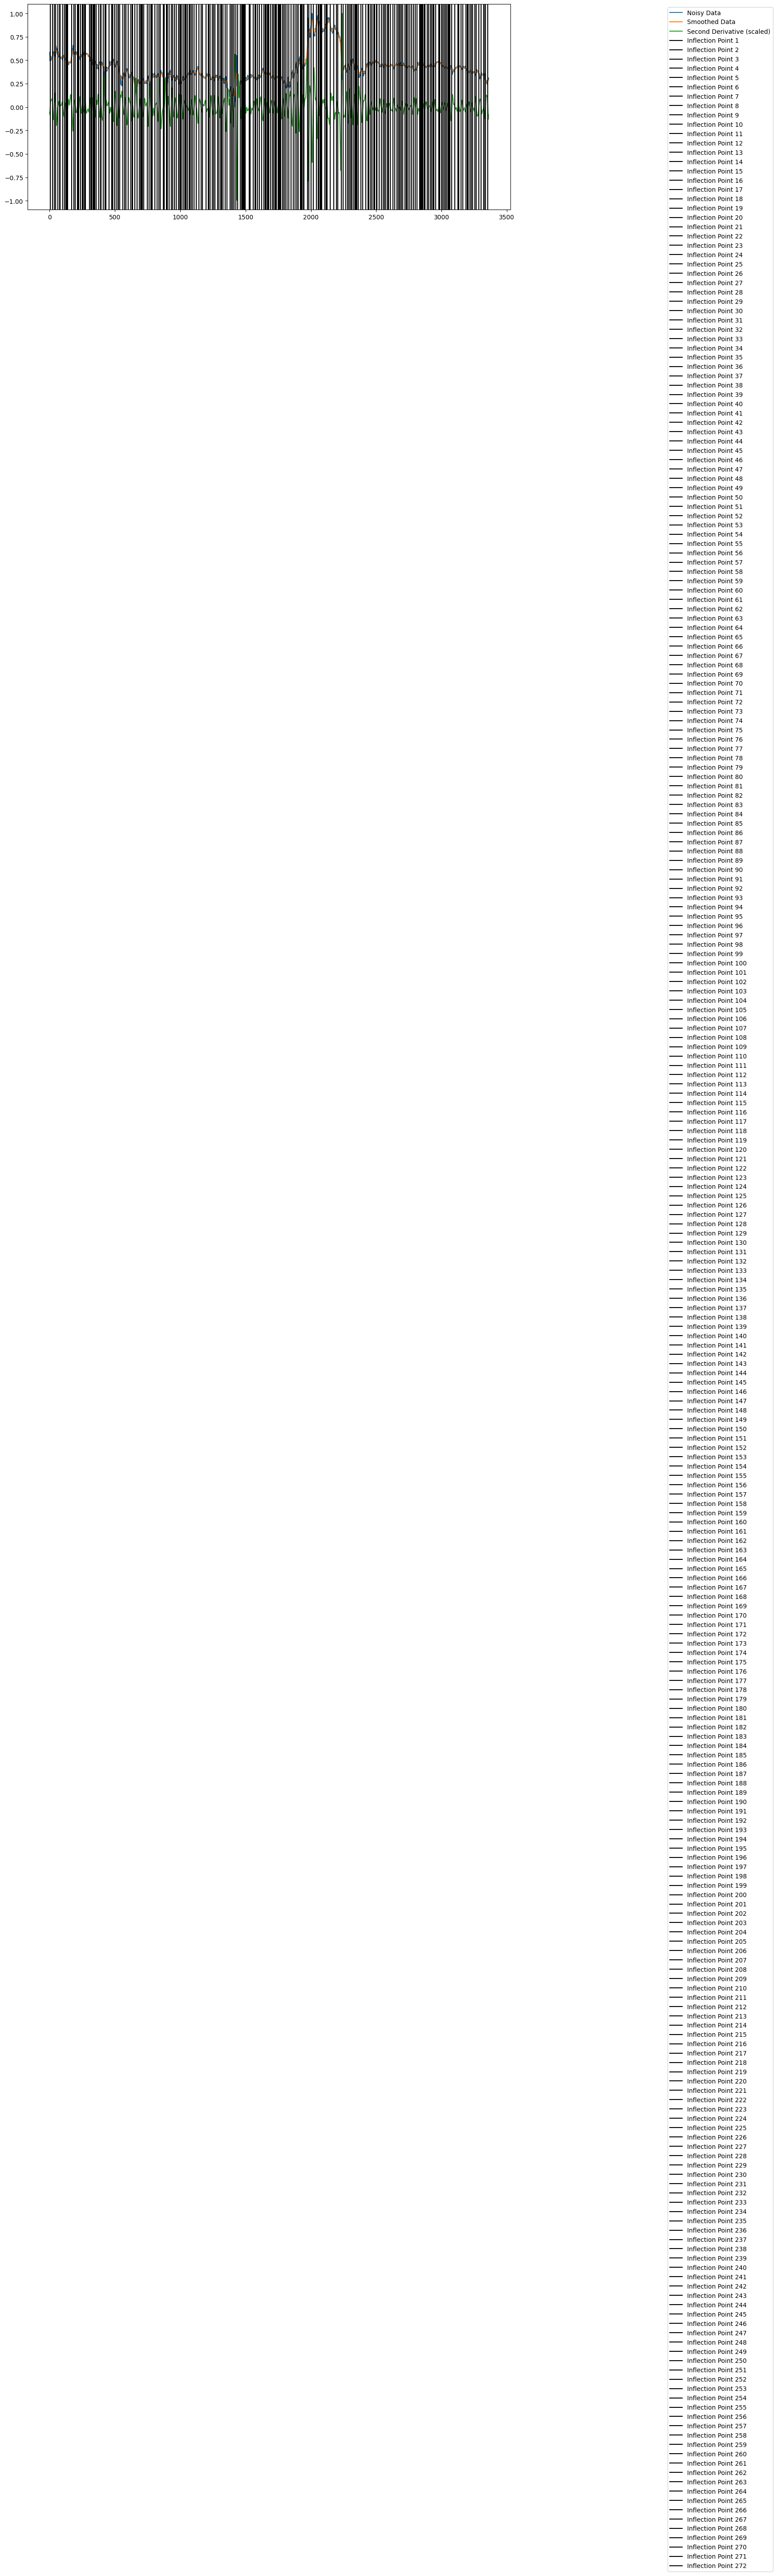

In [55]:
# noisy data
raw = asset.df["close"].values

# Normalize
raw = ( raw - min(raw) ) / ( max(raw) - min(raw) )

# smooth
smooth = gaussian_filter1d(raw, p1) # 20 because there are 20 time slots in an hour

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

asset.df.loc[ asset.df.iloc[ infls ].index,  "inflection"] = True
asset.df["smoth"] = smooth
asset.df["smoth"] = asset.df["smoth"].diff() > 0

asset.df[ "buy" ] = asset.df["smoth"] & asset.df["inflection"]

asset = sell_column( asset, 0.0015 )

# plot results
plt.figure( figsize=(14,6) )
plt.plot(raw, label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))


In [59]:
def rule_validation(asset):
    buy = False
    price_bought = None
    price_sold = None
    returns = []
    asset.df["rsi"] = asset.rsi(15)
    asset.df["rsi_pct"] = asset.rsi_smoth_slope(15, 10, 2)
    df = asset.df[ (asset.df["buy"] == True) | ( asset.df["sell"] == True ) ]
    df = df.replace(np.nan, 0)
    df = df[ (df[ "buy" ] != df["buy"].shift()) | (df[ "sell" ] != df["sell"].shift()) ]
    for i in range(len(df)):
        if not buy and df.iloc[i]["buy"] :
            buy = True
            price_bought = df.iloc[i]["close"]
            date_bought = df.index[ i ]
            rsi = df.iloc[i]["rsi"]
            rsi_pct = df.iloc[i]["rsi_pct"]

            trans = [ date_bought, price_bought , rsi, rsi_pct]
        
        elif buy and df.iloc[i]["sell"]:
            buy = False
            price_sold = df.iloc[i]["close"]
            date_sold = df.index[ i ]
            
            trans += [ date_sold, price_sold ]
            returns.append( trans )

    df = pd.DataFrame(returns, columns = ["date_bought", "bought", "rsi", "rsi_pct","date_sold", "sold"] )
    df["returns"] = ((df["sold"] / df["bought"]) - 1).round(3)
    df[ "acc" ] = (df["sold"] / df["bought"]).cumprod().round(3)
    # df["open"] = df["date_sold"] - df["date_bought"]

    return df

In [60]:
r = rule_validation(asset)

In [61]:
r

,date_bought,bought,rsi,rsi_pct,date_sold,sold,returns,acc
0,2023-09-03 19:30:00,25965.69,52.128198,0.000000,2023-09-03 19:33:00,26014.93,0.002,1.002
1,2023-09-03 20:36:00,26000.00,54.393813,-0.017807,2023-09-03 20:48:00,26072.00,0.003,1.005
2,2023-09-03 23:21:00,25962.35,50.556498,0.037469,2023-09-04 03:06:00,26004.36,0.002,1.006
3,2023-09-04 04:09:00,25983.62,46.784861,-0.025665,2023-09-04 07:15:00,26010.00,0.001,1.007
4,2023-09-04 08:06:00,25990.69,57.344039,0.013616,2023-09-04 13:24:00,25910.61,-0.003,1.004
5,2023-09-04 14:03:00,25879.34,47.502071,-0.017801,2023-09-04 15:33:00,25955.53,0.003,1.007
6,2023-09-04 17:03:00,25852.38,52.107099,0.009771,2023-09-04 17:12:00,25917.06,0.003,1.010
7,2023-09-04 18:06:00,25903.16,55.080837,-0.002156,2023-09-04 22:39:00,25796.50,-0.004,1.006
8,2023-09-04 23:00:00,25778.31,54.241771,0.015385,2023-09-04 23:36:00,25833.90,0.002,1.008
9,2023-09-05 01:21:00,25745.03,38.659545,0.022499,2023-09-05 01:30:00,25784.10,0.002,1.009


### Testing

In [22]:
def guassian_filtering(asset, p1 = 20):
    # noisy data
    raw = asset.df["close"].values

    # Normalize
    raw = ( raw - min(raw) ) / ( max(raw) - min(raw) )

    # smooth
    smooth = gaussian_filter1d(raw, p1) # 20 because there are 20 time slots in an hour

    # compute second derivative
    smooth_d2 = np.gradient(np.gradient(smooth))

    # find switching points
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]

    asset.df.loc[ asset.df.iloc[ infls ].index,  "inflection"] = True
    asset.df["smoth"] = smooth
    asset.df["smoth"] = asset.df["smoth"].diff(1) > 0
    asset.df["rsi"] = (asset.rsi_smoth( 10, 5 ) < 70).rolling( 3 ).sum() == 3

    asset.df[ "buy" ] = asset.df["smoth"] & asset.df["inflection"]

    asset = sell_column( asset, 0.0015 )

    return rule_validation(asset)
    # plot results
    # plt.figure( figsize=(14,6) )
    # plt.plot(raw, label='Noisy Data')
    # plt.plot(smooth, label='Smoothed Data')
    # plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
    # for i, infl in enumerate(infls, 1):
    #     plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
    # plt.legend(bbox_to_anchor=(1.55, 1.0))



In [72]:
r = []
for p1 in [2,3,4,5,6]:
    gaussian_results = pipeline2( guassian_filtering , p1 = p1)
    r.append ( gaussian_results[["acc", "net", "max_drawdown", "spread", "sharpe", "transactions"]].mean() )

In [73]:
pd.concat(r, axis = 1)

,0,1,2,3,4
acc,1.522733,1.404200,1.307467,1.256067,1.216600
net,0.002442,0.002520,0.002595,0.002573,0.002558
max_drawdown,-0.009133,-0.009067,-0.006333,-0.005867,-0.007333
spread,0.021133,0.019067,0.017467,0.015400,0.015733
sharpe,1.452604,1.657184,1.805678,1.640266,1.715667
transactions,151.466667,122.333333,98.533333,85.266667,73.600000


0.0015
acc              1.089333
net              0.002748
max_drawdown    -0.000200
spread           0.007800
sharpe           2.327733
transactions    31.866667

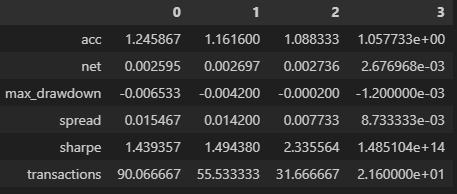

With RSI at 0.0015
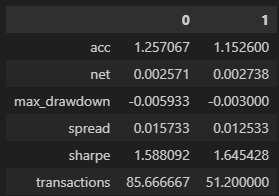

## Gaussian Filtering + RSI + RSI Smoth Std

### Discovery

In [10]:
def gf_rsi_rsistd(asset, p1 = 2, thr = 70, rsi_length1 = 10, rsi_rolling = 6, rsistd_length = 10, rsistd_smoth = 5, std_length = 5, std_thr = 3):
    # noisy data
    raw = asset.df["close"].values

    # Normalize
    raw = ( raw - min(raw) ) / ( max(raw) - min(raw) )

    # smooth
    smooth = gaussian_filter1d(raw, p1) # 20 because there are 20 time slots in an hour

    # compute second derivative
    smooth_d2 = np.gradient(np.gradient(smooth))

    # find switching points
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]

    asset.df.loc[ asset.df.iloc[ infls ].index,  "inflection"] = True
    asset.df["smoth"] = smooth
    asset.df["smoth"] = asset.df["smoth"].diff(1) > 0

    asset.df["rsi"] = (asset.rsi( rsi_length1 ) < thr).rolling( rsi_rolling ).sum() == rsi_rolling

    asset.df["rsi_smoth_std"] = asset.rsi_smoth( rsistd_length, rsistd_smoth ).rolling( std_length ).std() < std_thr

    asset.df[ "buy" ] = asset.df["smoth"] & asset.df["inflection"] & asset.df["rsi"] & asset.df["rsi_smoth_std"]

    asset = sell_column( asset, 0.0015 )

    return rule_validation(asset)


In [17]:
param_dict = {
    "p1":[2],
    "thr": [ 70, 75],
    "rsi_length1":[7, 10, 15],
    "rsi_rolling":[6, 7],
    "rsistd_length":[ 15, 20],
    "rsistd_smoth":[5, 10],
    "std_length":[5, 10],
    "std_thr":[3, 3.5]
}

In [18]:
param_grid = ParameterGrid( param_dict )
len(param_grid)

192

In [19]:
r = []
for param in param_grid:
    gaussian_results = pipeline2( gf_rsi_rsistd , **param)
    r.append ( gaussian_results[["acc", "net", "max_drawdown", "spread", "sharpe", "transactions", "mean_open_time", "max_open_time"]].mean() )

C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()
C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source
No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source


C:\Users\ramon\AppData\Local\Temp/ipykernel_2376/1345839349.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe = net / return_df["returns"].std()


No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source
No info from source


In [27]:
r = pd.DataFrame(r)
r.sort_values(by = "acc", ascending = False, inplace = True)
r

,acc,net,max_drawdown,spread,sharpe,transactions,mean_open_time,max_open_time
99,1.463417,0.002497,-0.010167,0.023667,1.134030,137.083333,0 days 00:15:11.571542306,0 days 01:45:45
107,1.452769,0.002471,-0.007308,0.021538,1.239406,136.153846,0 days 00:14:45.023840479,0 days 01:44:04.615384615
123,1.435643,0.002437,-0.006429,0.020071,1.260159,130.071429,0 days 00:15:40.488361865,0 days 01:44:08.571428571
105,1.435462,0.002463,-0.007308,0.021538,1.231353,133.230769,0 days 00:14:37.916859532,0 days 01:43:09.230769230
186,1.433643,0.002430,-0.006429,0.019929,1.210696,128.642857,0 days 00:16:32.042464427,0 days 01:44:08.571428571
...,...,...,...,...,...,...,...,...
4,1.245500,0.002477,-0.009143,0.021357,1.366411,81.357143,0 days 00:16:07.024449995,0 days 01:57:38.571428571
36,1.236857,0.002443,-0.008929,0.021143,1.419290,79.142857,0 days 00:16:16.069574360,0 days 02:06:51.428571428
38,1.232769,0.002426,-0.007308,0.020462,1.542775,76.384615,0 days 00:17:06.489640597,0 days 02:08:32.307692307
6,1.224929,0.002439,-0.006857,0.019214,inf,73.071429,0 days 00:16:28.893484676,0 days 01:51:38.571428571


Ninguno con un valor debajo de 1, por lo que ninguna estrategia perdio dinero.

In [24]:
r[ r["acc"] < 1 ]

,acc,net,max_drawdown,spread,sharpe,transactions,mean_open_time,max_open_time


In [29]:
paramgrid = pd.DataFrame(param_grid)

In [31]:
df_r = pd.concat([r, paramgrid], axis = 1)

In [33]:
df_r.sort_values(by = "acc", ascending=False)

,acc,net,max_drawdown,spread,sharpe,transactions,mean_open_time,max_open_time,p1,rsi_length1,rsi_rolling,rsistd_length,rsistd_smoth,std_length,std_thr,thr
99,1.463417,0.002497,-0.010167,0.023667,1.134030,137.083333,0 days 00:15:11.571542306,0 days 01:45:45,2,10,7,15,5,5,3.5,75
107,1.452769,0.002471,-0.007308,0.021538,1.239406,136.153846,0 days 00:14:45.023840479,0 days 01:44:04.615384615,2,10,7,15,10,5,3.5,75
123,1.435643,0.002437,-0.006429,0.020071,1.260159,130.071429,0 days 00:15:40.488361865,0 days 01:44:08.571428571,2,10,7,20,10,5,3.5,75
105,1.435462,0.002463,-0.007308,0.021538,1.231353,133.230769,0 days 00:14:37.916859532,0 days 01:43:09.230769230,2,10,7,15,10,5,3.0,75
186,1.433643,0.002430,-0.006429,0.019929,1.210696,128.642857,0 days 00:16:32.042464427,0 days 01:44:08.571428571,2,15,7,20,10,5,3.5,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.245500,0.002477,-0.009143,0.021357,1.366411,81.357143,0 days 00:16:07.024449995,0 days 01:57:38.571428571,2,7,6,15,5,10,3.0,70
36,1.236857,0.002443,-0.008929,0.021143,1.419290,79.142857,0 days 00:16:16.069574360,0 days 02:06:51.428571428,2,7,7,15,5,10,3.0,70
38,1.232769,0.002426,-0.007308,0.020462,1.542775,76.384615,0 days 00:17:06.489640597,0 days 02:08:32.307692307,2,7,7,15,5,10,3.5,70
6,1.224929,0.002439,-0.006857,0.019214,inf,73.071429,0 days 00:16:28.893484676,0 days 01:51:38.571428571,2,7,6,15,5,10,3.5,70


In [35]:
# df_r.to_csv( "results/dummy/gaussian_rsi_rsistd.csv", index = False , mode="a")